In [1]:
import os
import pickle

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygmo as pg
# import seaborn as sns
import tellurium as te
import itertools

from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.odbm.odbm_main import ModelBuilder
from src.fitting.pygmo_problems import SBML_Barebone_Multi_Fly

In [ ]:
os.getcwd()

Iterate through all factor labels for enzymes and metabolites. Condense into one variable called parameter_labels

In [2]:
r_biosyn = te.loads('results/240707_VNMetGly_BIOSYN_train-test/240621_VN_Metabolism_Gly_BIOSYN_fitted.sbml')

In [3]:
pvals = {p:r_biosyn[p] for p in r_biosyn.getGlobalParameterIds() if 'p_EC' in p}
plabels = list(pvals.keys())

metabolites = [s for s in r_biosyn.getFloatingSpeciesIds() if 'EC' not in s]
rstr = r_biosyn.getSBML()
vlabels = [v for v in [(rstr[rstr.find('<initialAssignment symbol="'+s+'">')+150:rstr.find('<initialAssignment symbol="'+s+'">')+150+len(s)]).split(' ')[0] for s in metabolites] if 'v' in v]

parameter_labels = plabels + vlabels

PAUSE ON THIS CODE BLOCK: Makes a dataframe of all possible perturbations of starting conditions of enzymes and metabolites in the system. These are the initial conditions we will want to break down into numpy arrays for "x".

In [ ]:
# # Example list of IDs and perturbation factors
# IDs = parameter_labels[:9]
# perturbation_factors = [1/10, 1, 10]

# # Initialize empty dataframe to store results
# concentration_df = pd.DataFrame(columns=['Perturbation ID'] + IDs)

# # Generate all combinations of perturbation factors for the IDs
# perturbation_combinations = list(itertools.product(perturbation_factors, repeat=len(IDs)))

# perturbation_id = 1
# for combination in perturbation_combinations:
#     # Track the concentration values for this perturbation
#     concentration_values = [perturbation_id]
#     for i, ID in enumerate(IDs):
#         initial_concentration = r_biosyn.getValue(ID)
#         perturbed_concentration = initial_concentration * combination[i]
#         concentration_values.append(perturbed_concentration)
#     concentration_df.loc[len(concentration_df)] = concentration_values
#     perturbation_id += 1

USING THIS CODE BLOCK FOR NOW: Instead of combinatorially perturbing every factor, this one only perturbs each parameter individually according to the perturbation factors.

In [4]:
IDs = parameter_labels
perturbation_factors = [1/10, 10]

# Initialize empty dataframe to store results
concentration_df = pd.DataFrame(columns=['Perturbation ID'] + IDs)

# Add the unaltered set of parameters as the first row
initial_concentration_values = [1]  # Start with ID 1
for param in IDs:
    initial_concentration = r_biosyn.getValue(param)
    initial_concentration_values.append(initial_concentration)
concentration_df.loc[len(concentration_df)] = initial_concentration_values

# Initialize perturbation ID counter
perturbation_id = 2  # Start from 2 since the first row is the unaltered set

# Generate perturbations by perturbing each parameter individually
for ID in IDs:
    for factor in perturbation_factors:
        # Track the concentration values for this perturbation
        concentration_values = [perturbation_id]
        for param in IDs:
            initial_concentration = r_biosyn.getValue(param)
            if param == ID:
                perturbed_concentration = initial_concentration * factor
            else:
                perturbed_concentration = initial_concentration
            concentration_values.append(perturbed_concentration)
        
        concentration_df.loc[len(concentration_df)] = concentration_values
        perturbation_id += 1

In [ ]:
concentration_df.to_csv('concentration_df.csv', index=False)

Calling SBML_Barebone_Multi_Fly. We'll want the input for calculate_metrics to be the numpy array we got from the above dataframe before running though.

In [5]:
mod = ['results/240707_VNMetGly_BIOSYN_train-test/240621_VN_Metabolism_Gly_BIOSYN_fitted.sbml']
parameter_labels = parameter_labels
tp = 60*60*8

In [6]:
species_ids = r_biosyn.getFloatingSpeciesIds()
count_c_species = len([spc for spc in species_ids if spc.startswith('C')])

In [7]:
peter = SBML_Barebone_Multi_Fly(mod, parameter_labels, tp, count_c_species*9)

In [ ]:
peter._setup_rr()
peter2 = pg.problem(peter)
peter2.fitness(concentration_df.iloc[20].values)

In [ ]:
concentration_df.iloc[18]

In [ ]:
concentration_df.head(20)

In [8]:
import pygmo as pg
peter2 = pg.problem(peter)

# setup the client (let python see all the CPUs)
import ipyparallel as ipp
import os
client = ipp.Client(profile='cheme-ecfers')
client[:].apply_sync(os.chdir,'/mmfs1/gscratch/cheme/mkcook/repos/ECFERS');
def set_affinity_on_worker():
    """When a new worker process is created, the affinity is set to all CPUs"""
    import os
    os.system("taskset -p 0xffffffffff %d" % os.getpid())
client[:].apply_sync(set_affinity_on_worker)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [9]:
# setup the batch_fitness_evaluator (hijacked to caluclate metrics instead of fitness)
from src.fitting.pygmo_bfes import mkcook_bfe
bfe = mkcook_bfe(client_kwargs={'profile':'cheme-ecfers'}, view_kwargs = {}, temp_dv_path = os.getcwd()+'/models/binaries', prob = peter2)
bfe.init_view(client_kwargs={'profile':'cheme-ecfers'}, view_kwargs = {})

In [10]:
# calculate the metrics
concentration_df = concentration_df.drop('Perturbation ID', axis=1)
metrics = bfe(peter2, concentration_df.to_numpy().reshape(-1))

Now that we have metrics, we need to turn it into a legible format!

In [23]:
# Reshape the metrics array into (153571, 9)
metrics_reshaped = metrics.reshape(153571, 9)

In [69]:
# Create the DataFrame with the specified column names
metrics_df = pd.DataFrame(metrics_reshaped, columns=['Final Concentration', 'Min Conc', 'Max Conc', 'Min Time', 'Max Time', 'Total Production', 'Production to Max', 'Half Max Time', 'Half Max Conc'])

In [70]:
# Generate Perturbation IDs
rows_per_id = 253
num_ids = 153571 // rows_per_id  # Calculate the number of unique IDs
perturbation_ids = np.repeat(np.arange(1, num_ids + 1), rows_per_id)

# If the total rows aren't exactly divisible, adjust the last batch
if len(perturbation_ids) < len(metrics_df):
    perturbation_ids = np.append(perturbation_ids, [num_ids] * (len(metrics_df) - len(perturbation_ids)))

# Insert the Perturbation ID column
metrics_df.insert(0, 'Perturbation ID', perturbation_ids)

compounds = []

for spc in species_ids:
    if spc.startswith('C'):
        compounds.append(spc)

rows_per_compound = 253

# Number of complete segments of compounds
num_segments = len(metrics_df) // rows_per_compound

# Generate the "Compound" column
compound_values = np.tile(compounds, num_segments)

# Ensure the length matches the DataFrame's number of rows
if len(compound_values) < len(metrics_df):
    compound_values = np.append(compound_values, compounds[:len(metrics_df) - len(compound_values)])

# Insert the "Compound" column after "Perturbation ID"
metrics_df.insert(1, 'Compound', compound_values)

If they have already been generated, proceed to the next chunk

In [104]:
metrics_df = pd.read_csv('results/coefficients/cleaned_metrics.csv', index=False)
finmets = metrics_df.dropna()

og_conc_df = pd.read_csv('concentration_df.csv')

In [138]:
# give me a protein or compound to change
# give me a compound to observe
# give me the metric you care about

def calc_coeffs(changed, observed, metric):
    # find the index of rows where they are different from row 0 (there will be 2, so i guess we should calculate two coefficients each time? i wonder if they are the same)
    i_diff = og_conc_df.index[og_conc_df[changed] != og_conc_df.loc[0, changed]].tolist()

    # calculate the denomenator for both of these by subtracting df.iloc[index][changed protien/compound] - df.iloc[0][changed protien/compound] over df.iloc[0][changed protien/compound]
    pert1 = og_conc_df.iloc[i_diff[0]][changed]
    pert2 = og_conc_df.iloc[i_diff[1]][changed]
    base = og_conc_df.iloc[0][changed]

    den1 = (pert1-base)/base
    den2 = (pert2-base)/base

    # take the perturbation IDs that correspond with these
    id1 = og_conc_df.iloc[i_diff[0]]['Perturbation ID']
    id2 = og_conc_df.iloc[i_diff[1]]['Perturbation ID']

    # locate the row in finmetsdf that has that pID and the compound you care about (user input!)
    # from both rows, take the metric the user cares about (user input!)
    met1 = finmets[(finmets['Perturbation ID'] == id1) & (finmets['Compound'] == observed)][metric].values[0]
    met2 = finmets[(finmets['Perturbation ID'] == id2) & (finmets['Compound'] == observed)][metric].values[0]

    # also find the row in finmetsdf that has a pID of 1 and the compound you care about (user input!) - this is the base val
    basemet = finmets[(finmets['Perturbation ID'] == 1) & (finmets['Compound'] == observed)][metric].values[0]

    # calculate the numerator for both of these by subtracting pert-base/base
    num1 = (met1-basemet)/basemet
    num2 = (met2-basemet)/basemet

    # calculate the coefficients by num/den
    coeff1 = num2/den2
    coeff2 = num1/den1

    avcoeff = (coeff1+coeff2)/2 # idk if we actually want the average, but this makes it easier for me for now

    return avcoeff

In [139]:
changed = 'v120'
observed = 'C12214'
metric = "Final Concentration"

In [140]:
calc_coeffs(changed, observed, metric)

4.8614151485613325e-08

In [149]:
params = []
for col in og_conc_df.columns:
    if col != 'Perturbation ID':
        params.append(col)

In [153]:
heatmap_data = pd.DataFrame(index=compounds, columns=params)

for param in params:
    for comp in compounds:
        try:
            heatmap_data.loc[comp, param] = calc_coeffs(param, comp, "Final Concentration")
        except IndexError as e:
            heatmap_data.loc[comp, param] = 0

/tmp/ipykernel_173/3577693523.py:30: RuntimeWarning:

invalid value encountered in scalar divide

/tmp/ipykernel_173/3577693523.py:31: RuntimeWarning:

invalid value encountered in scalar divide



KeyboardInterrupt: 

In [154]:
heatmap_data

,p_EC5319,p_EC27111,p_EC31311,p_EC41213,p_EC5311,p_EC2723,p_EC42111,p_EC2792,p_EC27140,p_EC1241,...,v243,v244,v245,v246,v247,v248,v249,v250,v252,v253
C12214,-0.000003,-0.021495,0.000006,-0.0,0.000001,0.00042,0.0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C00111,0.000187,0.142402,0.000586,-0.065006,-0.097304,-0.003911,0.0,0.0,-0.000027,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C00345,0.000005,-0.026058,0.000008,0.0,-0.0,0.00038,0.0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C00005,-0.000067,0.54348,-0.000187,-0.000006,0.0,-0.005446,0.0,-0.0,-0.000001,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C00020,-0.000798,-5017233.036845,-3.436046,0.53681,-0.094226,-0.02623,0.000705,0.84727,-0.003044,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C11440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C01639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C03125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C05379,0.000059,-0.189158,0.000873,-0.0,-0.0,0.004625,0.0,0.0,0.000001,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
heatmap_data.to_csv('results/coefficients/240807_heatmap.csv')

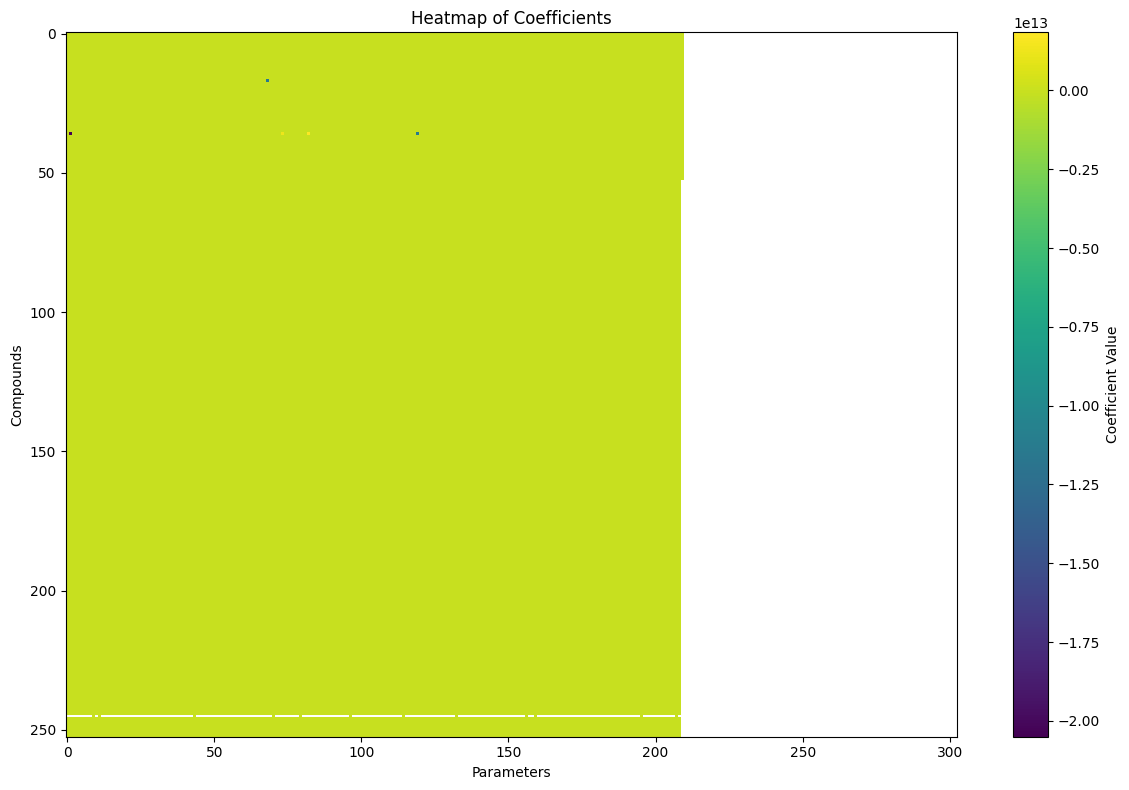

In [155]:
# Convert the DataFrame to a numpy array for plotting
heatmap_array = heatmap_data.astype(float).values

# Create the heatmap using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(heatmap_array, aspect='auto', cmap='viridis', interpolation='nearest')

# Add color bar
plt.colorbar(label='Coefficient Value')

# # Set the ticks and labels
# plt.xticks(ticks=np.arange(len(parameters)), labels=parameters, rotation=45, ha='right')
# plt.yticks(ticks=np.arange(len(observed_values)), labels=observed_values)

# Add labels and title
plt.xlabel('Parameters')
plt.ylabel('Compounds')
plt.title('Heatmap of Coefficients')

# Display the plot
plt.tight_layout()
plt.show()